In [2]:
import os, sys

# find repo root (looks for liars_poker/ or pyproject.toml)
def find_repo_root(start_dir: str) -> str:
    cur = os.path.abspath(start_dir)
    for _ in range(6):
        if os.path.isdir(os.path.join(cur, "liars_poker")) or os.path.exists(os.path.join(cur, "pyproject.toml")):
            return cur
        parent = os.path.dirname(cur)
        if parent == cur:
            break
        cur = parent
    return os.path.abspath(os.path.join(start_dir, "..", ".."))

NB_DIR = os.getcwd()
REPO_ROOT = find_repo_root(NB_DIR)
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

ARTIFACTS_ROOT = os.path.join(REPO_ROOT, "artifacts")
os.makedirs(ARTIFACTS_ROOT, exist_ok=True)

print("repo root   :", REPO_ROOT)
print("artifacts   :", ARTIFACTS_ROOT)


repo root   : c:\Users\adidh\Documents\liars_poker
artifacts   : c:\Users\adidh\Documents\liars_poker\artifacts


In [3]:
from liars_poker import (
    GameSpec, Env, InfoSet, Rules,
    Policy, TabularPolicy, CommitOnceMixture, RandomPolicy,
    eval_both_seats
)

from liars_poker.training.dense_fsp import dense_fsp_loop
from liars_poker.training.fsp_utils import plot_exploitability_series, save_fsp_run, dense_fsp_resume

from liars_poker.algo.br_exact import best_response_exact
from liars_poker.algo.br_mc import best_response_mc

from liars_poker.algo.br_exact_dense_to_dense import best_response_exact as best_response_denser


from liars_poker.policies.tabular_dense import DenseTabularPolicy
from liars_poker.serialization import save_policy

In [4]:
spec = GameSpec(ranks=3, suits=4, hand_size=3, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True)
rules = Rules(spec)

29

In [ ]:
from datetime import datetime

time_right_now_string = datetime.now().strftime("%Y%m%d-%H%M%S")
spec = all_specs[27]

pol, info = dense_fsp_loop(spec=spec, episodes=10, episodes_test=0)
plot_exploitability_series(info)


# short_form = spec.to_short_str() + '___'
# short_form += time_right_now_string
# save_fsp_run(run_id=short_form, policy=pol, info=info, spec=spec)


In [6]:
# Trendline helper for dense_fsp_loop logs
import math
import numpy as np

def plot_with_trend(info, *, last_n=None, targets=(1e-2, 2e-3)):
    series = info.get("exploitability_series", [])
    if not series:
        print("No exploitability data.")
        return None

    # Use predicted_avg when available, else rollout_avg
    y_vals = []
    for pt in series:
        y = pt.get("predicted_avg")
        if y is None:
            y = pt.get("rollout_avg", 0.0)
        y_vals.append(2*float(y)-1)

    n = len(y_vals)
    x_vals = np.arange(1, n + 1, dtype=float)

    if last_n is None:
        last_n = max(5, n - 50)
    last_n = min(max(2, int(last_n)), n)

    x_fit = x_vals[-last_n:]
    y_fit = np.array(y_vals[-last_n:], dtype=float)
    mask = y_fit > 0
    if mask.sum() < 2:
        print("Not enough positive points to fit a trendline.")
        plot_exploitability_series(info)
        return None

    logx = np.log10(x_fit[mask])
    logy = np.log10(y_fit[mask])
    slope, intercept = np.polyfit(logx, logy, 1)

    ax = plot_exploitability_series(info)
    if ax is None:
        return None
    y_pred = 10 ** (intercept + slope * np.log10(x_vals))
    ax.plot(x_vals, y_pred, linestyle='--', color='black', alpha=0.7, label='trend (power law)')
    ax.legend()

    print(f"Fit (log10): y = 10^( {intercept:.4f} + {slope:.4f} * log10(x) )")

    for target in targets:
        if target <= 0:
            continue
        # Solve for x: log10(y) = intercept + slope * log10(x)
        # log10(x) = (log10(target) - intercept) / slope
        if slope == 0:
            print(f"Target {target:.4g}: slope is 0, no crossing predicted.")
            continue
        logx_star = (math.log10(target) - intercept) / slope
        x_star = 10 ** logx_star
        print(f"Target {target:.4g}: predicted at step ~{x_star:.1f}")

    return ax


Fit (log10): y = 10^( 0.1618 + -0.4442 * log10(x) )
Target 0.01: predicted at step ~73614.8
Target 0.002: predicted at step ~2757754.3


<Axes: title={'center': 'Exploitability over FSP iterations'}, xlabel='Episode', ylabel='Exploitability'>

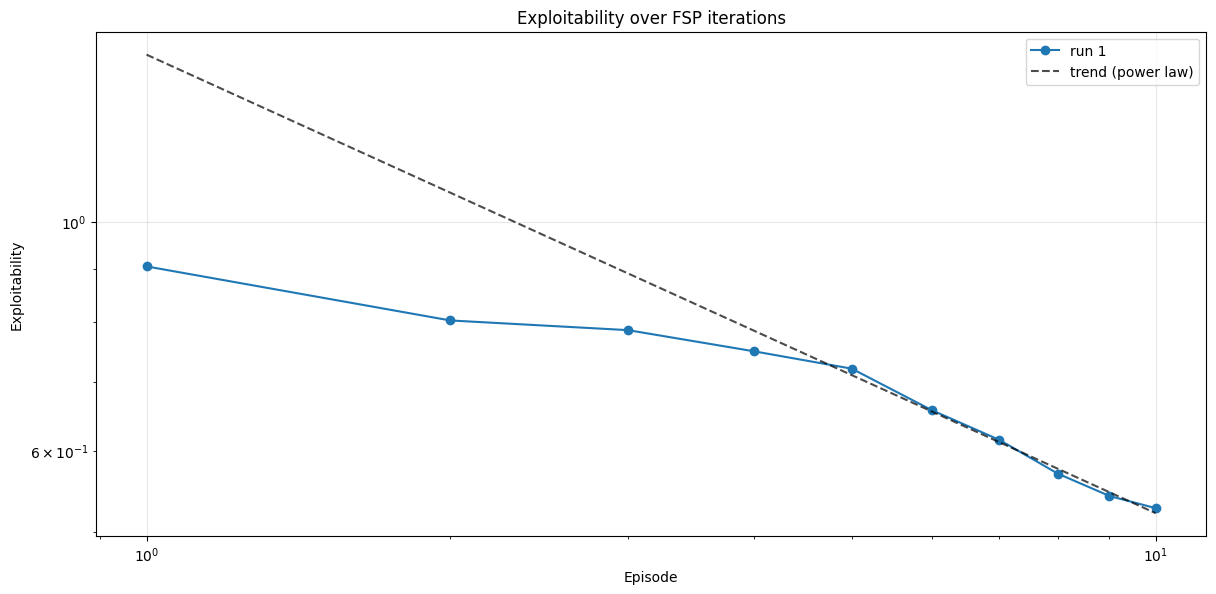

In [27]:
plot_with_trend(info)